In [2]:
import os
import pandas as pd

# Function to parse data from a single file
def parse_file(file_path):
    data = []
    date = os.path.basename(file_path).split('.')[0]  # Extract date from filename
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 10:
                time = parts[0]
                am_pm = parts[1]
                temp = parts[2]
                dew_point = parts[4]
                humidity = parts[6]
                wind_speed = parts[9]
                
                # Check if 'temp', 'dew_point', 'humidity', and 'wind_speed' are digits
                if temp.isdigit() and dew_point.isdigit() and humidity.isdigit() and wind_speed.isdigit():
                    data.append([date, time, am_pm, int(temp), int(dew_point), int(humidity), int(wind_speed)])
                    
    return data

# Function to process data for a city and return the DataFrame
def process_city_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            all_data.extend(parse_file(file_path))
    df = pd.DataFrame(all_data, columns=['date', 'time', 'am/pm', 'temp', 'dew_point', 'humidity', 'wind_speed'])
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'] + ' ' + df['am/pm'], format='%Y-%m-%d %I:%M %p')
    df.drop(['date', 'time', 'am/pm'], axis=1, inplace=True)
    df.sort_values(by='datetime', inplace=True)
    return df

# Folder paths for different cities
folder_paths = {
    'nyc': '/Users/samdvorin/Desktop/code/542/weather-prediction/nyc_weather_data',
    'chi': '/Users/samdvorin/Desktop/code/542/weather-prediction/chi_weather_data',
    'mia': '/Users/samdvorin/Desktop/code/542/weather-prediction/miami_weather_data',
    'aus': '/Users/samdvorin/Desktop/code/542/weather-prediction/austin_weather_data'
}

# Dictionary to store DataFrames for each city
city_dfs = {}

# Process data for each city and store the DataFrame
for city, folder_path in folder_paths.items():
    city_dfs[city] = process_city_data(folder_path)

# Example usage: Print the first few rows of NYC DataFrame
print(city_dfs['nyc'].head())
print(city_dfs['chi'].head())
print(city_dfs['mia'].head())
print(city_dfs['aus'].head())


     temp  dew_point  humidity  wind_speed            datetime
228    46         32        58           5 2024-02-01 00:51:00
202    39         30        70           0 2024-02-01 01:46:00
203    40         30        68           0 2024-02-01 01:51:00
204    39         30        70           5 2024-02-01 02:46:00
205    40         29        65           6 2024-02-01 02:51:00
     temp  dew_point  humidity  wind_speed            datetime
212    39         34        82          13 2024-02-01 00:53:00
186    37         33        86           8 2024-02-01 01:53:00
187    37         33        86           9 2024-02-01 02:53:00
188    36         32        86           9 2024-02-01 03:53:00
189    37         33        86          10 2024-02-01 04:53:00
     temp  dew_point  humidity  wind_speed            datetime
164    64         47        54           0 2024-02-01 00:53:00
141    61         52        72           8 2024-02-01 01:53:00
142    59         50        72           5 2024-02-01 0

Mean Squared Error: 17.856735340892854


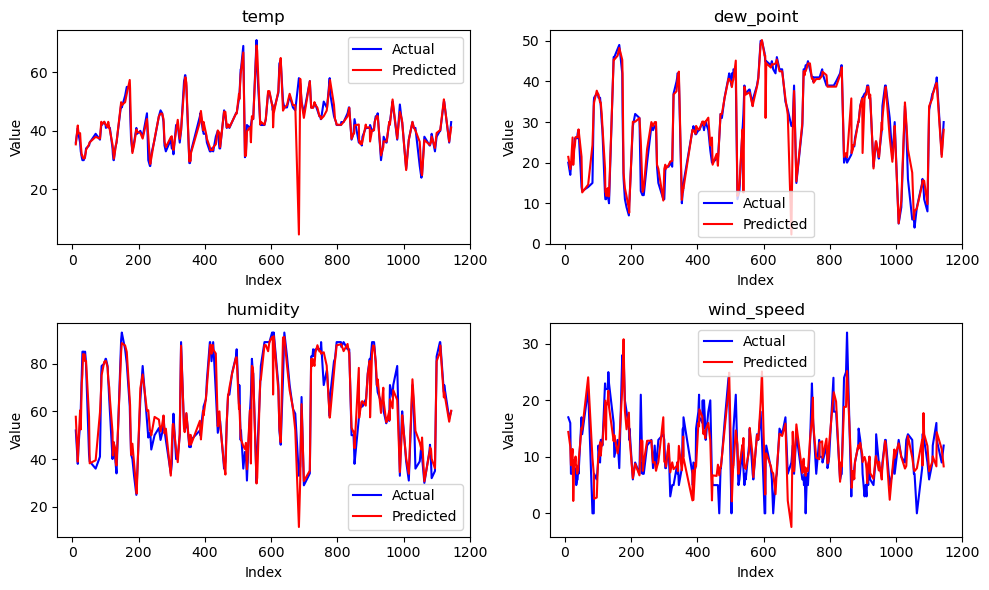

In [49]:
''' 

Trying to work more on state consideration

'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = city_dfs['nyc'].copy()
# First, let's convert the datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Next, let's create lag features for each variable
lag_features = ['temp', 'dew_point', 'humidity', 'wind_speed']
num_lags = 1  # You can adjust this value based on how many previous states you want to consider

for feature in lag_features:
    for i in range(1, num_lags + 1):
        df[f'{feature}_lag_{i}'] = df[feature].shift(i)

# Drop rows with NaN resulting from shifting
df.dropna(inplace=True)

# Split the data into features (X) and target variable (y)
X = df.drop(['temp', 'dew_point', 'humidity', 'wind_speed', 'datetime'], axis=1)
y = df[['temp', 'dew_point', 'humidity', 'wind_speed']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model with feature names
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Sort the test data by datetime for plotting
sorted_indices = y_test.index.argsort()
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plot actual vs predicted values for each variable
plt.figure(figsize=(10, 6))

for i, feature in enumerate(['temp', 'dew_point', 'humidity', 'wind_speed']):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_sorted.index, y_test_sorted[feature], label='Actual', color='blue')
    plt.plot(y_test_sorted.index, y_pred_sorted[:, i], label='Predicted', color='red')
    plt.title(feature)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()





In [50]:
'''  
combining all data together

 '''


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Assuming city_dfs is a dictionary containing dataframes for each city
# Combine data from all cities into one dataframe
combined_df = pd.concat(city_dfs.values())


# Function to shift the target variables to align with features
def shift_target(df, target_cols, shift_by=1):
    df_targets = df[target_cols].shift(-shift_by)
    df_targets.columns = [col + '_next' for col in target_cols]
    return pd.concat([df, df_targets], axis=1)

# Define the target columns
target_cols = ['temp', 'dew_point', 'humidity', 'wind_speed']

# Shift the target variables to align with features
combined_df = shift_target(combined_df, target_cols)

# Drop rows with NaN values (last rows will have NaN as we shifted the target)
combined_df = combined_df.dropna()

# Separate features and target variable
X = combined_df.drop(columns=[col+'_next' for col in target_cols] + ['datetime'])
y = combined_df[[col+'_next' for col in target_cols]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your predictive model (example using RandomForestRegressor)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate your model
score = model.score(X_test, y_test)
print("Model Score:", score)


Model Score: 0.8206265452858224


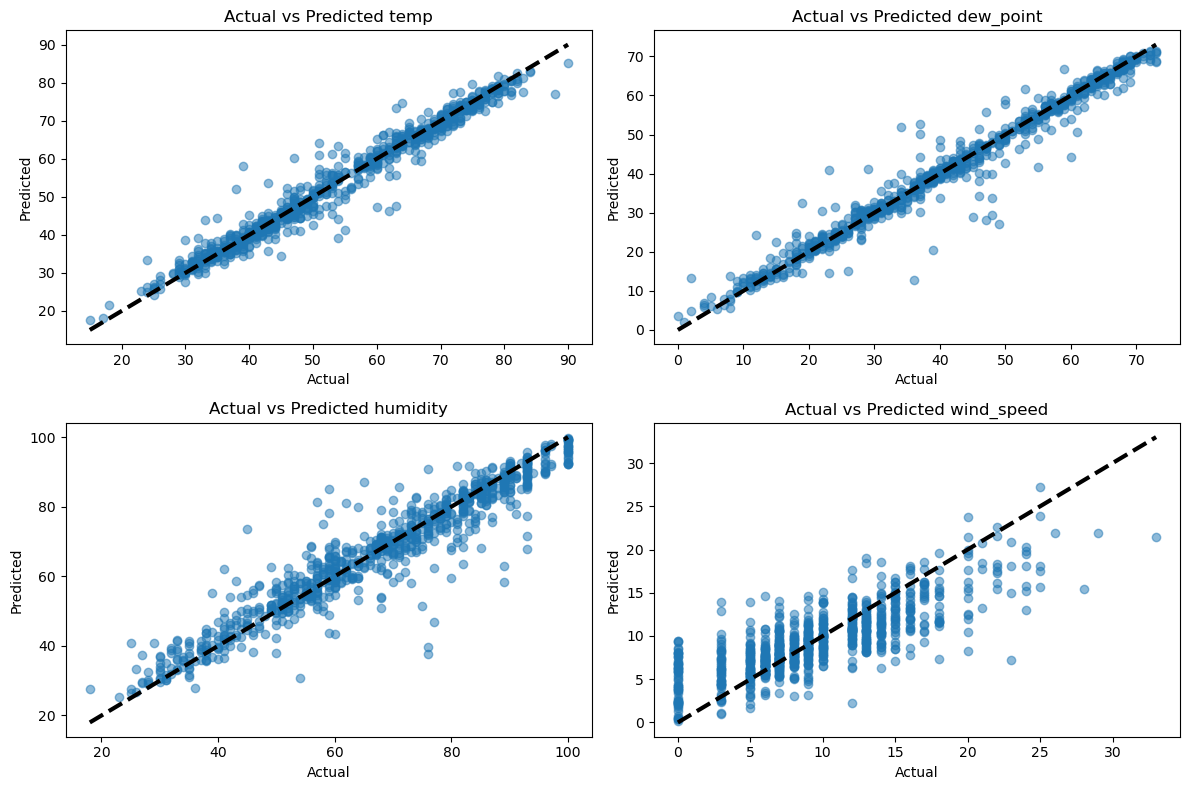

In [73]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot actual vs predicted for each target variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    target_col = target_cols[i]
    ax.scatter(y_test[target_col+'_next'], y_pred[:, i], alpha=0.5)
    ax.plot([y_test[target_col+'_next'].min(), y_test[target_col+'_next'].max()], 
            [y_test[target_col+'_next'].min(), y_test[target_col+'_next'].max()], 'k--', lw=3)
    ax.set_title(f'Actual vs Predicted {target_col}')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

plt.tight_layout()
plt.show()

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

# Assuming city_dfs is a dictionary containing dataframes for each city
# Combine data from all cities into one dataframe
combined_df = pd.concat(city_dfs.values())

# Extract cyclic features for time
combined_df['hour_of_day'] = combined_df['datetime'].dt.hour
combined_df['day_of_week'] = combined_df['datetime'].dt.dayofweek
combined_df['month'] = combined_df['datetime'].dt.month
combined_df['day_of_year'] = combined_df['datetime'].dt.dayofyear

# Function to create lagged features
def create_lagged_features(df, target_col, lag):
    lagged_features = []
    for i in range(1, lag + 1):
        lagged_features.append(df[target_col].shift(i).rename(f'{target_col}_lag_{i}'))
    return pd.concat([df] + lagged_features, axis=1)

# Define the target columns
target_cols = ['temp', 'dew_point', 'humidity', 'wind_speed']

# Create lagged features for temperature
lag = 24  # Lag for 24 hours
for col in target_cols:
    combined_df = create_lagged_features(combined_df, col, lag)

# Function to shift the target variables to align with features
def shift_target(df, target_cols, shift_by=1):
    df_targets = df[target_cols].shift(-shift_by)
    df_targets.columns = [col + '_next' for col in target_cols]
    return pd.concat([df, df_targets], axis=1)

# Shift the target variables to align with features
combined_df = shift_target(combined_df, target_cols)

# Drop rows with NaN values (last rows will have NaN as we shifted the target)
combined_df = combined_df.dropna()

# Separate features and target variable
X = combined_df.drop(columns=[col+'_next' for col in target_cols] + ['datetime'])
y = combined_df[[col+'_next' for col in target_cols]]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train your predictive model (example using RandomForestRegressor)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate your model
score = model.score(X_test, y_test)
print("Model Score:", score)


Model Score: 0.8674804974666426


In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from datetime import timedelta

# Assuming city_dfs is a dictionary containing dataframes for each city
# Combine data from all cities into one dataframe
combined_df = pd.concat(city_dfs.values())

# Extract cyclic features for time
combined_df['hour_of_day'] = combined_df['datetime'].dt.hour
combined_df['day_of_week'] = combined_df['datetime'].dt.dayofweek
combined_df['month'] = combined_df['datetime'].dt.month
combined_df['day_of_year'] = combined_df['datetime'].dt.dayofyear

# Function to create lagged features
def create_lagged_features(df, target_col, lag):
    lagged_features = []
    for i in range(1, lag + 1):
        lagged_features.append(df[target_col].shift(i).rename(f'{target_col}_lag_{i}'))
    return pd.concat([df] + lagged_features, axis=1)

# Define the target columns
target_cols = ['temp', 'dew_point', 'humidity', 'wind_speed']

# Create lagged features for temperature
lag = 24  # Lag for 24 hours
for col in target_cols:
    combined_df = create_lagged_features(combined_df, col, lag)

# Function to shift the target variables to align with features
def shift_target(df, target_cols, shift_by=1):
    df_targets = df[target_cols].shift(-shift_by)
    df_targets.columns = [col + '_next' for col in target_cols]
    return pd.concat([df, df_targets], axis=1)

# Shift the target variables to align with features
combined_df = shift_target(combined_df, target_cols)

# Drop rows with NaN values (last rows will have NaN as we shifted the target)
combined_df = combined_df.dropna()

# Separate features and target variable
X = combined_df.drop(columns=[col+'_next' for col in target_cols] + ['datetime'])
y = combined_df[[col+'_next' for col in target_cols]]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


'''   
# Train Bayesian Ridge Regression model
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train, y_train['temp_next'].ravel())  # Select 'temp_next' and reshape to 1D array

# Evaluate the model
score = bayesian_ridge_model.score(X_test, y_test['temp_next'])
print("Model Score:", score)

'''

''' 
# Train Bayesian Ridge Regression model with increased alpha for regularization
bayesian_ridge_model = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)
bayesian_ridge_model.fit(X_train, y_train['temp_next'].ravel())  # Select 'temp_next' and reshape to 1D array

# Evaluate the model
score = bayesian_ridge_model.score(X_test, y_test['temp_next'])
print("Model Score:", score)

'''

# Train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train['temp_next'].ravel())

# Evaluate the model
score = rf_model.score(X_test, y_test['temp_next'])
print("Model Score:", score)


Model Score: 0.9702570970076767


In [89]:
import numpy as np

# Function to predict the next 24 hours of temperature for NYC
def predict_next_24_hours(model, scaler, city_df):
    # Extract features for prediction
    features = city_df.drop(columns=['datetime'])
    
    # Extract the last datetime
    last_datetime = city_df['datetime'].iloc[-1]
    
    # Create datetime objects for the next 24 hours
    next_24_hours = [last_datetime + timedelta(hours=i) for i in range(1, 25)]
    
    # Create features for the next 24 hours
    next_24_hours_features = pd.DataFrame(columns=features.columns)
    for dt in next_24_hours:
        hour_of_day = dt.hour
        day_of_week = dt.dayofweek
        month = dt.month
        day_of_year = dt.dayofyear
        next_hour_features = pd.DataFrame([[hour_of_day, day_of_week, month, day_of_year]], 
                                          columns=['hour_of_day', 'day_of_week', 'month', 'day_of_year'])
        next_24_hours_features = pd.concat([next_24_hours_features, next_hour_features], ignore_index=True)
    
    # Create lagged features for temperature
    for col in target_cols:
        next_24_hours_features = create_lagged_features(next_24_hours_features, col, lag)
    
    # Scale the features
    next_24_hours_features_scaled = scaler.transform(next_24_hours_features)
    
    # Replace NaN values with zeros (or you can use other imputation methods)
    next_24_hours_features_scaled = np.nan_to_num(next_24_hours_features_scaled)
    
    # Predict the next 24 hours of temperature
    next_24_hours_predictions = model.predict(next_24_hours_features_scaled)
    
    # Return datetime objects and predicted temperatures
    return next_24_hours, next_24_hours_predictions

# Predict the next 24 hours of temperature for NYC
nyc_next_24_hours_datetime, nyc_next_24_hours_predictions = predict_next_24_hours(gradient_boosting_model, scaler, city_dfs['nyc'])

# Display the predictions
for dt, temp in zip(nyc_next_24_hours_datetime, nyc_next_24_hours_predictions):
    print(f"DateTime: {dt}, Predicted Temperature: {temp}")


DateTime: 2024-03-15 16:51:00, Predicted Temperature: 53.41
DateTime: 2024-03-15 17:51:00, Predicted Temperature: 53.43
DateTime: 2024-03-15 18:51:00, Predicted Temperature: 53.41
DateTime: 2024-03-15 19:51:00, Predicted Temperature: 53.45
DateTime: 2024-03-15 20:51:00, Predicted Temperature: 53.44
DateTime: 2024-03-15 21:51:00, Predicted Temperature: 53.32
DateTime: 2024-03-15 22:51:00, Predicted Temperature: 53.31
DateTime: 2024-03-15 23:51:00, Predicted Temperature: 51.96
DateTime: 2024-03-16 00:51:00, Predicted Temperature: 53.09
DateTime: 2024-03-16 01:51:00, Predicted Temperature: 53.36
DateTime: 2024-03-16 02:51:00, Predicted Temperature: 53.36
DateTime: 2024-03-16 03:51:00, Predicted Temperature: 53.36
DateTime: 2024-03-16 04:51:00, Predicted Temperature: 53.32
DateTime: 2024-03-16 05:51:00, Predicted Temperature: 53.38
DateTime: 2024-03-16 06:51:00, Predicted Temperature: 53.43
DateTime: 2024-03-16 07:51:00, Predicted Temperature: 53.73
DateTime: 2024-03-16 08:51:00, Predicted

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import timedelta

# Assuming city_dfs is a dictionary containing dataframes for each city
# Combine data from all cities into one dataframe
combined_df = city_dfs['nyc']

# Extract cyclic features for time
combined_df['hour_of_day'] = combined_df['datetime'].dt.hour
combined_df['day_of_week'] = combined_df['datetime'].dt.dayofweek
combined_df['month'] = combined_df['datetime'].dt.month
combined_df['day_of_year'] = combined_df['datetime'].dt.dayofyear

# Define the target column
target_col = 'temp'

# Function to create lagged features
def create_lagged_features(df, target_col, lag):
    lagged_features = []
    for i in range(1, lag + 1):
        lagged_features.append(df[target_col].shift(i).rename(f'{target_col}_lag_{i}'))
    return pd.concat([df] + lagged_features, axis=1)

# Create lagged features for temperature
lag = 24  # Lag for 24 hours
combined_df = create_lagged_features(combined_df, target_col, lag)

# Drop rows with NaN values (last rows will have NaN as we shifted the target)
combined_df = combined_df.dropna()

# Define the complex function to fit
def complex_sine_function(x, *params):
    result = np.zeros_like(x, dtype=np.float64)  # Ensure result has the same dtype as x
    for i in range(0, len(params), 4):
        amplitude, frequency, phase, offset = params[i:i+4]
        result += amplitude * np.sin(2 * np.pi * frequency * x + phase) + float(offset)  # Cast offset to float64
    return result

# Define the x and y data
x_data = np.arange(len(combined_df))  # Use the index as x data
y_data = combined_df[target_col].values

# Define an initial guess for the parameters with higher amplitude values
initial_guess = [2.0, 1.0, 0.5, 0.5] * (len(combined_df.columns) // 4)  # Initial guess for all sine functions

# Fit the complex sine function to the data using Trust Region Reflective (TRF) algorithm
popt, pcov = curve_fit(complex_sine_function, x_data, y_data, p0=initial_guess, method='trf', maxfev=10000)

# Generate the predicted values using the fitted complex sine function
y_predicted = complex_sine_function(x_data, *popt)

# Plot the actual and predicted values
plt.plot(x_data, y_data, label='Actual')
plt.plot(x_data, y_predicted, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
